## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch with CUDA
# !pip install torch torchvision torchaudio

# # Install additional dependencies
# !pip install datasets matplotlib pandas pillow timm torcheval torchtnt==0.2.0 tqdm

# # Install utility packages
# !pip install cjm_pandas_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

## Importing the Required Dependencies

In [38]:
# Import Python Standard Library dependencies
from copy import copy
import datetime
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
import urllib.request

# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img, get_img_files
from cjm_psl_utils.core import download_file, file_extract
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor
from cjm_torchvision_tfms.core import ResizeMax, PadSquare

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy 
import numpy as np

# Import pandas module for data manipulation
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image

# Import timm library
import timm

# Import PyTorch dependencies
import torch
import torch.nn as nn
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.utils.data import Dataset, DataLoader

import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

from torchtnt.utils import get_module_summary
from torcheval.metrics import MulticlassAccuracy

# Import tqdm for progress bar
from tqdm.auto import tqdm

## Setting Up the Project

### Setting a Random Number Seed

In [4]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

### Setting the Device and Data Type

In [5]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('mps', torch.float32)

### Setting the Directory Paths

In [6]:
# The name for the project
project_name = f"cjm_image_classifier"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# Define path to store datasets
dataset_dir = Path("./data/hagrid_cjm/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Project Directory:": project_dir,
    "Dataset Directory:": dataset_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

Project Directory:,cjm_image_classifier
Dataset Directory:,data/hagrid_cjm
Archive Directory:,data/hagrid_cjm/../Archive


## Loading and Exploring the Dataset

### Setting the Dataset Path

In [7]:
# Set the name of the dataset
dataset_name = 'hagrid-classification-512p-no-gesture-150k-zip'

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'cj-mills/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name.removesuffix("-zip")}.zip')

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name.removesuffix("-zip")}')

# Creating a Series with the dataset name and paths and converting it to a DataFrame for display
pd.Series({
    "HuggingFace Dataset:": hf_dataset, 
    "Archive Path:": archive_path, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

HuggingFace Dataset:,cj-mills/hagrid-classification-512p-no-gesture-150k-zip
Archive Path:,data/hagrid_cjm/../Archive/hagrid-classification-512p-no-gesture-150k.zip
Dataset Path:,data/hagrid_cjm/hagrid-classification-512p-no-gesture-150k


### Downloading the Dataset

In [8]:
# Construct the HuggingFace Hub dataset URL
dataset_url = f"https://huggingface.co/datasets/{hf_dataset}/resolve/main/{dataset_name.removesuffix('-zip')}.zip"
print(f"HuggingFace Dataset URL: {dataset_url}")

# Set whether to delete the archive file after extracting the dataset
delete_archive = True

# Download the dataset if not present
if dataset_path.is_dir():
    print("Dataset folder already exists")
else:
    print("Downloading dataset...")
    download_file(dataset_url, archive_dir)    
    
    print("Extracting dataset...")
    file_extract(fname=archive_path, dest=dataset_dir)
    
    # Delete the archive if specified
    if delete_archive: archive_path.unlink()

HuggingFace Dataset URL: https://huggingface.co/datasets/cj-mills/hagrid-classification-512p-no-gesture-150k-zip/resolve/main/hagrid-classification-512p-no-gesture-150k.zip
Dataset folder already exists


### Get Image Folders

In [9]:
img_folder_paths = [folder for folder in dataset_path.iterdir() if folder.is_dir()]
# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({"Image Folder": [folder.name for folder in img_folder_paths]})

,Image Folder
0,dislike
1,like
2,stop_inverted
3,ok
4,mute
5,two_up
6,no_gesture
7,stop
8,peace
9,two_up_inverted


### Get Image File Paths

In [10]:
# Get a list of all image file paths from the image folders
class_file_paths = [get_img_files(folder) for folder in img_folder_paths]

# Get all image files in the 'img_dir' directory
img_paths = [
    file
    for folder in class_file_paths # Iterate through each image folder
    for file in folder # Get a list of image files in each image folder
]

# Print the number of image files
print(f"Number of Images: {len(img_paths)}")

# Display the first five entries using a Pandas DataFrame
pd.DataFrame(img_paths).head()

Number of Images: 153735


,0
0,data/hagrid_cjm/hagrid-classification-512p-no-gesture-150k/dislike/8325339a-0a18-43d6-ba89-cc6aa9b98c8e.jpeg
1,data/hagrid_cjm/hagrid-classification-512p-no-gesture-150k/dislike/f619decc-63f2-4264-a1e7-414a9ee8e2cf.jpeg
2,data/hagrid_cjm/hagrid-classification-512p-no-gesture-150k/dislike/90228303-79df-4db8-ae04-0042c5899b48.jpeg
3,data/hagrid_cjm/hagrid-classification-512p-no-gesture-150k/dislike/4d0c9934-6bd1-4b51-9504-f7a777332640.jpeg
4,data/hagrid_cjm/hagrid-classification-512p-no-gesture-150k/dislike/7e5071b0-db7b-433a-87de-a56427e5b26e.jpeg


### Inspecting the Class Distribution

#### Get image classes

In [11]:
# Get the number of samples for each image class
class_counts_dict = {folder[0].parent.name:len(folder) for folder in class_file_paths}

# Get a list of unique labels
class_names = list(class_counts_dict.keys())

# Display the labels and the corresponding number of samples using a Pandas DataFrame
class_counts = pd.DataFrame.from_dict({'Count':class_counts_dict})
class_counts

,Count
dislike,7028
like,6823
stop_inverted,7142
ok,6924
mute,7139
two_up,7346
no_gesture,27823
stop,6893
peace,6965
two_up_inverted,6967


#### Visualize the class distribution

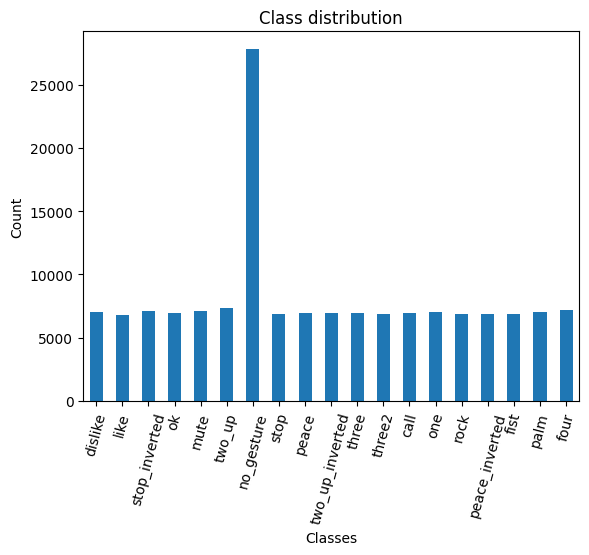

In [12]:
# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_names)  # Set the x-axis tick labels
plt.xticks(rotation=75)  # Rotate x-axis labels
plt.gca().legend().set_visible(False)
plt.show()

### Visualizing Sample Images

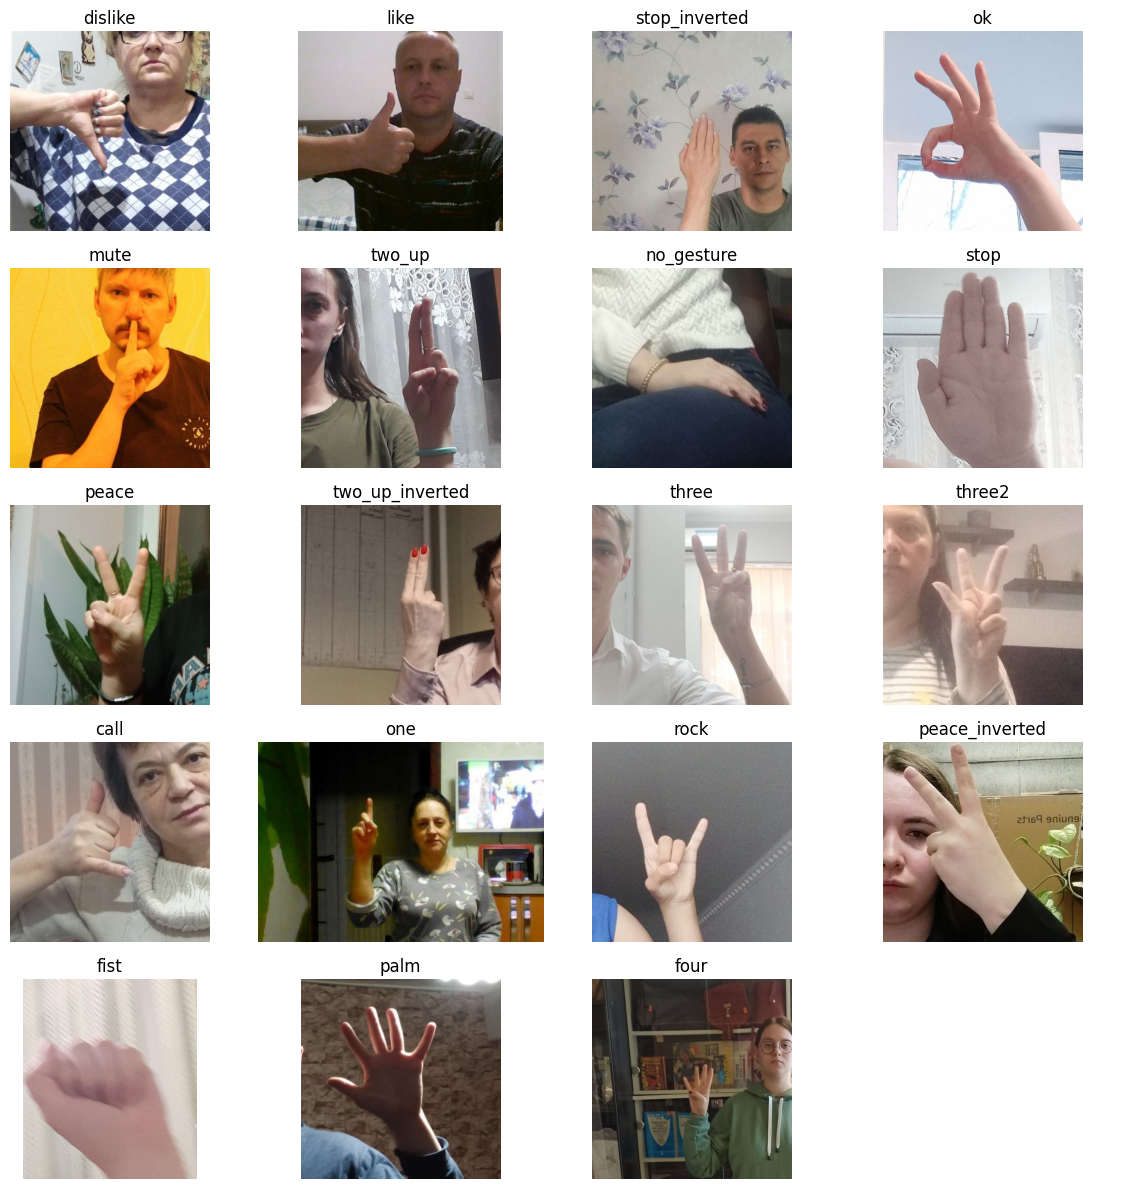

In [13]:
# Create a list to store the first image found for each class
sample_image_paths = [folder[0] for folder in class_file_paths]
sample_labels = [path.parent.stem for path in sample_image_paths]

# Calculate the number of rows and columns
grid_size = math.floor(math.sqrt(len(sample_image_paths)))
n_rows = grid_size+(1 if grid_size**2 < len(sample_image_paths) else 0)
n_cols = grid_size

# Create a figure for the grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,12))

for i, ax in enumerate(axs.flatten()):
    # If we have an image for this subplot
    if i < len(sample_image_paths) and sample_image_paths[i]:
        # Add the image to the subplot
        ax.imshow(np.array(Image.open(sample_image_paths[i])))
        # Set the title to the corresponding class name
        ax.set_title(sample_labels[i])
        # Remove the axis
        ax.axis('off')
    else:
        # If no image, hide the subplot
        ax.axis('off')

# Display the grid
plt.tight_layout()
plt.show()

## Selecting a Model

### Exploring Available Models

In [14]:
pd.DataFrame(timm.list_models('fastvit*', pretrained=True))

,0
0,fastvit_ma36.apple_dist_in1k
1,fastvit_ma36.apple_in1k
2,fastvit_mci0.apple_mclip
3,fastvit_mci1.apple_mclip
4,fastvit_mci2.apple_mclip
5,fastvit_s12.apple_dist_in1k
6,fastvit_s12.apple_in1k
7,fastvit_sa12.apple_dist_in1k
8,fastvit_sa12.apple_in1k
9,fastvit_sa24.apple_dist_in1k


### Inspecting the Model Configuration

In [16]:
# Import the mobilenet module
from timm.models import fastvit as model_family

# Define the base model variant to use
base_model = 'fastvit_s12'
version = "apple_dist_in1k"

# Get the default configuration of the chosen model
model_cfg = model_family.default_cfgs[base_model].default.to_dict()

# Show the default configuration values
pd.DataFrame.from_dict(model_cfg, orient='index')

,0
url,
hf_hub_id,timm/
custom_load,False
input_size,"(3, 256, 256)"
fixed_input_size,False
interpolation,bicubic
crop_pct,0.9
crop_mode,center
mean,"(0.485, 0.456, 0.406)"
std,"(0.229, 0.224, 0.225)"


### Retrieving Normalization Statistics

In [17]:
# Retrieve normalization statistics (mean and std) specific to the pretrained model
mean, std = model_cfg['mean'], model_cfg['std']
norm_stats = (mean, std)
norm_stats

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

### Loading the Model

In [18]:
# Create a pretrained MobileNet model with the number of output classes equal to the number of class names
# 'timm.create_model' function automatically downloads and initializes the pretrained weights
model = timm.create_model(f'{base_model}.{version}', pretrained=True, num_classes=len(class_names))

# Set the device and data type for the model
model = model.to(device=device, dtype=dtype)

# Add attributes to store the device and model name for later reference
model.device = device
model.name = f'{base_model}.{version}'

### Summarizing the Model

In [19]:
# Define the input to the model
test_inp = torch.randn(1, 3, 256, 256).to(device)

# Get a summary of the model as a Pandas DataFrame
summary_df = markdown_to_pandas(f"{get_module_summary(model, [test_inp])}")

# Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[(summary_df.index == 0) | (summary_df['Type'] == 'Conv2d')]

# Remove the column "Contains Uninitialized Parameters?"
summary_df.drop('Contains Uninitialized Parameters?', axis=1)

,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs,Backward FLOPs,In size,Out size
0,FastVit,8.5 M,8.5 M,34.0 M,1.8 G,17.3 G,"[1, 3, 256, 256]","[1, 19]"
6,Conv2d,1.7 K,1.7 K,6.9 K,28.3 M,31.5 M,"[1, 3, 256, 256]","[1, 64, 128, 128]"
11,Conv2d,192,192,768,3.1 M,3.1 M,"[1, 3, 256, 256]","[1, 64, 128, 128]"
20,Conv2d,576,576,2.3 K,2.4 M,153 M,"[1, 64, 128, 128]","[1, 64, 64, 64]"
25,Conv2d,64,64,256,262 k,17.0 M,"[1, 64, 128, 128]","[1, 64, 64, 64]"
35,Conv2d,4.1 K,4.1 K,16.4 K,16.8 M,33.6 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
56,Conv2d,576,576,2.3 K,2.4 M,153 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
61,Conv2d,64,64,256,262 k,17.0 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
69,Conv2d,3.1 K,3.1 K,12.5 K,12.8 M,834 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
73,Conv2d,16.6 K,16.6 K,66.6 K,67.1 M,134 M,"[1, 64, 64, 64]","[1, 256, 64, 64]"


## Preparing the Data

### Training-Validation Split

In [20]:
# Shuffle the image paths
random.shuffle(img_paths)

# Define the percentage of the images that should be used for training
train_pct = 0.9
val_pct = 0.1

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_paths)*train_pct)
val_split = int(len(img_paths)*(train_pct+val_pct))

# Split the subset of image paths into training and validation sets
train_paths = img_paths[:train_split]
val_paths = img_paths[train_split:]

# Print the number of images in the training and validation sets
pd.Series({
    "Training Samples:": len(train_paths),
    "Validation Samples:": len(val_paths)
}).to_frame().style.hide(axis='columns')

Training Samples:,138361
Validation Samples:,15374


### Data Augmentation

#### Set training image size

In [21]:
train_sz = 288

#### Initialize image transforms

In [22]:
# Set the fill color for padding images
fill = (0,0,0)

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=fill)

# # Create a TrivialAugmentWide object
trivial_aug = transforms.TrivialAugmentWide(fill=fill)

#### Test the transforms

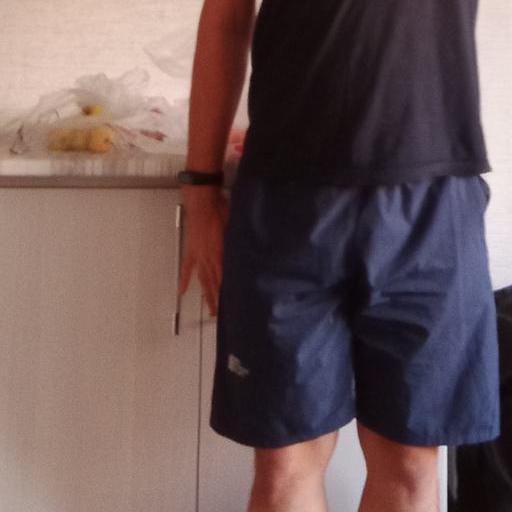

In [23]:
sample_img = Image.open(img_paths[11])
sample_img

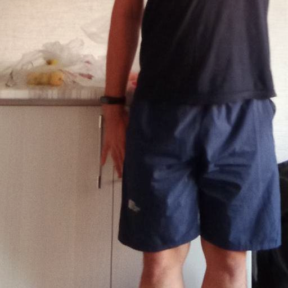

Source Image:,"(512, 512)"
Resized Image:,"(288, 288)"
Padded Image:,"(288, 288)"
Resized Padded Image:,"(288, 288)"


In [24]:
# Augment the image
augmented_img = trivial_aug(sample_img)

# Resize the image
resized_img = resize_max(augmented_img)

# Pad the image
padded_img = pad_square(resized_img)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img = resize(padded_img)

# Display the annotated image
display(resized_padded_img)

pd.Series({
    "Source Image:": sample_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [25]:
class ImageDataset(Dataset):
    """
    A PyTorch Dataset class for handling images.
    
    This class extends PyTorch's Dataset and is designed to work with image data. 
    It supports loading images, and applying transformations.

    Attributes:
        img_paths (list): List of image file paths.
        class_to_idx (dict): Dictionary mapping class names to class indices.
        transforms (callable, optional): Transformations to be applied to the images.
    """

    def __init__(self, img_paths, class_to_idx, transforms=None):
        """
        Initializes the ImageDataset with image keys and other relevant information.
        
        Args:
            img_paths (list): List of image file paths.
            class_to_idx (dict): Dictionary mapping class names to class indices.
            transforms (callable, optional): Transformations to be applied to the images.
        """
        super(Dataset, self).__init__()
        
        self._img_paths = img_paths
        self._class_to_idx = class_to_idx
        self._transforms = transforms

    def __len__(self):
        """
        Returns the number of items in the dataset.
        
        Returns:
            int: Number of items in the dataset.
        """
        return len(self._img_paths)
        
    def __getitem__(self, index):
        """
        Retrieves an item from the dataset at the specified index.
        
        Args:
            index (int): Index of the item to retrieve.

        Returns:
            tuple: A tuple containing the image and its corresponding label.
        """
        img_path = self._img_paths[index]
        image, label = self._load_image(img_path)
        
        # Applying transformations if specified
        if self._transforms:
            image = self._transforms(image)

        return image, label

    def _load_image(self, img_path):
        """
        Loads an image from the provided image path.
        
        Args:
            img_path (string): Image path.
            Returns:
        tuple: A tuple containing the loaded image and its corresponding target data.
        """
        # Load the image from the file path
        image = Image.open(img_path).convert('RGB')
        
        return image, self._class_to_idx[img_path.parent.name]

### Image Transforms

In [26]:
# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max, 
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(*norm_stats),
])

# Define the transformations for training and validation datasets
# Note: Data augmentation is performed only on the training dataset
train_tfms = transforms.Compose([
    trivial_aug,
    resize_pad_tfm, 
    final_tfms
])
valid_tfms = transforms.Compose([resize_pad_tfm, final_tfms])

### Initialize Datasets

In [27]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the dataset using the defined transformations
train_dataset = ImageDataset(train_paths, class_to_idx, train_tfms)
valid_dataset = ImageDataset(val_paths, class_to_idx, valid_tfms)

# Print the number of samples in the training and validation datasets
pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset)}
).to_frame().style.hide(axis='columns')

Training dataset size:,138361
Validation dataset size:,15374


### Inspect Samples

**Inspect training set sample**

Label: peace_inverted


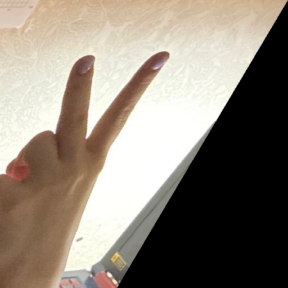

In [28]:
# Get the label for the first image in the training set
print(f"Label: {class_names[train_dataset[0][1]]}")

# Get the first image in the training set
TF.to_pil_image(denorm_img_tensor(train_dataset[0][0], *norm_stats))

**Inspect validation set sample**

Label: rock


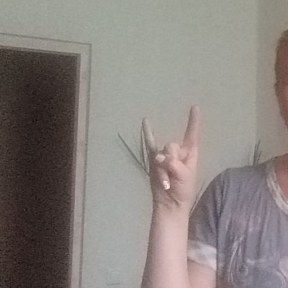

In [29]:
# Get the label for the first image in the validation set
print(f"Label: {class_names[valid_dataset[0][1]]}")

# Get the first image in the validation set
TF.to_pil_image(denorm_img_tensor(valid_dataset[0][0], *norm_stats))

### Training Batch Size

In [30]:
bs = 32

### Initialize DataLoaders

In [31]:
# Set the number of worker processes for loading data. This should be the number of CPUs available.
# num_workers = multiprocessing.cpu_count()#//2
num_workers = 0

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    # 'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    # 'pin_memory': 'mps' in device,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    # 'pin_memory_device': device if 'mps' in device else '',  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
}

# Create DataLoader for training data. Data is shuffled for every epoch.
train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)

# Create DataLoader for validation data. Shuffling is not necessary for validation data.
valid_dataloader = DataLoader(valid_dataset, **data_loader_params)

# Print the number of batches in the training and validation DataLoaders
print(f'Number of batches in train DataLoader: {len(train_dataloader)}')
print(f'Number of batches in validation DataLoader: {len(valid_dataloader)}')

Number of batches in train DataLoader: 4324
Number of batches in validation DataLoader: 481


## Fine-tuning the Model

### Define the Training Loop

In [39]:
# Function to run a single training/validation epoch
def run_epoch(model, dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch_id, is_training):
    # Set model to training mode if 'is_training' is True, else set to evaluation mode
    model.train() if is_training else model.eval()
    
    # Reset the performance metric
    metric.reset()
    # Initialize the average loss for the current epoch 
    epoch_loss = 0
    # Initialize progress bar with total number of batches in the dataloader
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")
    
    # Iterate over data batches
    for batch_id, (inputs, targets) in enumerate(dataloader):
        # Move inputs and targets to the specified device (e.g., GPU)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Enables gradient calculation if 'is_training' is True
        with torch.set_grad_enabled(is_training):
            # Automatic Mixed Precision (AMP) context manager for improved performance
            # with autocast(torch.device(device).type):
            outputs = model(inputs) # Forward pass
            loss = torch.nn.functional.cross_entropy(outputs, targets) # Compute loss
        
        # Update the performance metric
        metric.update(outputs.detach().cpu(), targets.detach().cpu())
        
        # If in training mode
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                
            optimizer.zero_grad()
        
        loss_item = loss.item()
        epoch_loss += loss_item
        # Update progress bar
        progress_bar.set_postfix(accuracy=metric.compute().item(), 
                                 loss=loss_item, 
                                 avg_loss=epoch_loss/(batch_id+1), 
                                 lr=lr_scheduler.get_last_lr()[0] if is_training else "")
        progress_bar.update()
        
        # If loss is NaN or infinity, stop training
        if is_training:
            stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
            assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message
        
    progress_bar.close()
    return epoch_loss / (batch_id + 1)

In [58]:
# Main training loop
def train_loop(model, train_dataloader, valid_dataloader, optimizer, metric, lr_scheduler, device, epochs, checkpoint_path, use_scaler=False):
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')

    # Iterate over each epoch
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run training epoch and compute training loss
        print(f"Epoch {epoch}/{epochs}\n")
        train_loss = run_epoch(model, train_dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch, is_training=True)
        # Run validation epoch and compute validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, metric, None, device, scaler, epoch, is_training=False)
        
        # If current validation loss is lower than the best one so far, save model and update best loss
        if valid_loss < best_loss:
            best_loss = valid_loss
            metric_value = metric.compute().item()
            torch.save(model.state_dict(), checkpoint_path)
            
            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss, 
                'metric_value': metric_value,
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }
            
            # Save best_loss and metric_value in a JSON file
            with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                json.dump(training_metadata, f)
    
        # Debugging outputs to ensure everything is working
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss}")
        print(f"Valid Loss: {valid_loss}")
        print(f"Best Valid Loss: {best_loss}")
        print(f"Metric Value: {metric_value}")

    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

### Set the Model Checkpoint Path

In [52]:
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(project_dir/f"{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

cjm_image_classifier/2024-06-28_00-55-37/fastvit_s12.apple_dist_in1k.pth


### Saving the Class Labels

In [54]:
# Save class labels
class_labels = {"classes": list(class_names)}

# Set file path
class_labels_path = checkpoint_dir/f"{dataset_name}-classes.json"

# Save class labels in JSON format
with open(class_labels_path, "w") as write_file:
    json.dump(class_labels, write_file)
    
print(class_labels_path)

cjm_image_classifier/2024-06-28_00-55-37/hagrid-classification-512p-no-gesture-150k-zip-classes.json


### Configure the Training Parameters

In [55]:
# Learning rate for the model
lr = 1e-3

# Number of training epochs
epochs = 3

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                   max_lr=lr, 
                                                   total_steps=epochs*len(train_dataloader))

# Performance metric: Multiclass Accuracy
metric = MulticlassAccuracy()

### Train the Model

In [ ]:
num_epochs = 3
scaler = None
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}")
    train_loss = run_epoch(model, train_dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch, is_training=True)
    print(f"Training loss for epoch {epoch+1}: {train_loss}")
    
    val_loss = run_epoch(model, valid_dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch, is_training=False)
    print(f"Validation loss for epoch {epoch+1}: {val_loss}")
    
    print(f"Finished epoch {epoch+1}/{num_epochs}")


In [59]:
train_loop(model=model, 
           train_dataloader=train_dataloader, 
           valid_dataloader=valid_dataloader, 
           optimizer=optimizer, 
           metric=metric, 
           lr_scheduler=lr_scheduler, 
           device=torch.device(device), 
           epochs=epochs, 
           checkpoint_path=checkpoint_path, 
           use_scaler=True)




Epochs:   0%|          | 0/3 [00:00<?, ?it/s]


TypeError: object of type 'int' has no len()

## Making Predictions with the Model

In [ ]:
# Choose an item from the validation set
test_file = val_paths[0]

# Open the test file
test_img = Image.open(test_file).convert('RGB')

# Set the minimum input dimension for inference 
input_img = resize_img(test_img, target_sz=train_sz, divisor=1)

# Convert the image to a normalized tensor and move it to the device
img_tensor = pil_to_tensor(input_img, *norm_stats).to(device=device)

# Make a prediction with the model
with torch.no_grad():
    pred = model(img_tensor)
        
# Scale the model predictions to add up to 1
pred_scores = torch.softmax(pred, dim=1)

# Get the highest confidence score
confidence_score = pred_scores.max()

# Get the class index with the highest confidence score and convert it to the class name
pred_class = class_names[torch.argmax(pred_scores)]

# Display the image
display(test_img)

print(f"Predicted Class: {pred_class}")

# Print the prediction data as a Pandas DataFrame for easy formatting
confidence_score_df = pd.DataFrame({
    'Confidence Score':{
        name:f'{score*100:.2f}%' for name, score in zip(class_names, pred_scores.cpu().numpy()[0])
    }
})
confidence_score_df

### Testing the Model on New Data

In [ ]:
file_name = 'pexels-elina-volkova-16191659.jpg'
# file_name = 'pexels-joshua-roberts-12922530.jpg'
# file_name = 'pexels-luke-barky-2899727.jpg'
# file_name = 'pexels-ketut-subiyanto-4584599.jpg'
# file_name = 'pexels-nataliya-vaitkevich-5411990.jpg'
# file_name = 'pexels-darina-belonogova-7886753.jpg'
# file_name = 'pexels-katrin-bolovtsova-6706013.jpg'
# file_name = 'pexels-leo-vinicius-3714450.jpg'
# file_name = 'pexels-diva-plavalaguna-6937816.jpg'

test_img_url = f"https://huggingface.co/datasets/cj-mills/pexel-hand-gesture-test-images/resolve/main/{file_name}"
test_img_path = Path(file_name)

if test_img_path.is_file():
    print("Image already exists.")
else:
    urllib.request.urlretrieve(test_img_url, test_img_path)
    print("Image downloaded.")

test_img = Image.open(test_img_path)
test_img

In [ ]:
# Set the minimum input dimension for inference 
infer_sz = train_sz

inp_img = resize_img(test_img.copy(), infer_sz)

# Convert the image to a normalized tensor and move it to the device
img_tensor = pil_to_tensor(inp_img, *norm_stats).to(device=device)

# Make a prediction with the model
with torch.no_grad():
    pred = model(img_tensor)
        
# Scale the model predictions to add up to 1
pred_scores = torch.softmax(pred, dim=1)

# Get the highest confidence score
confidence_score = pred_scores.max()

# Get the class index with the highest confidence score and convert it to the class name
pred_class = class_names[torch.argmax(pred_scores)]

# Display the image
display(test_img)

print(f"Predicted Class: {pred_class}")

# Print the prediction data as a Pandas DataFrame for easy formatting
confidence_score_df = pd.DataFrame({
    'Confidence Score':{
        name:f'{score*100:.2f}%' for name, score in zip(class_names, pred_scores.cpu().numpy()[0])
    }
})
confidence_score_df